In [1]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import scipy as scp
import scipy.stats as scps
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load my own functions
import dnnregressor_train_eval_keras as dnnk
import make_data_wfpt as mdw
from kde_training_utilities import kde_load_data
import ddm_data_simulation as ddm_sim

In [2]:
# Load Model
model_path = os.getcwd() + '/keras_models/dnnregressor_kde_ddm_flexbound_05_03_19_20_15_59/model_0' 
ckpt_path = os.getcwd() + '/keras_models/dnnregressor_kde_ddm_flexbound_05_03_19_20_15_59/ckpt_0_80'
model = keras.models.load_model(model_path)
model.load_weights(ckpt_path)

In [3]:
# Define the likelihood function DDM
def log_p_ddm(params = [0, 1, 0.9], model = [], data = []):
    feature_pd = pd.DataFrame(np.zeros((data[0].shape[0], 5)), columns = ['v', 'a', 'w', 'rt', 'choice'])
    feature_pd['rt'] = data[0]
    feature_pd['choice'] = data[1]
    feature_pd['v'] = params[0]
    feature_pd['a'] = params[1]
    feature_pd['w'] = params[2]
    prediction = model.predict(feature_pd)
    prediction[prediction < 1e-29] = 1e-29
    return(- np.sum(np.log(prediction)))

In [4]:
# Define the likelihood function DDM-FLEXBOUND
def log_p_flexbound(params = [0, 1, 0.9], model = [], data = []):
    feature_pd = pd.DataFrame(np.zeros((data[0].shape[0], 7)), columns = ['v', 'a', 'w', 'c1', 'c2', 'rt', 'choice'])
    feature_pd['rt'] = data[0]
    feature_pd['choice'] = data[1]
    feature_pd['v'] = params[0]
    feature_pd['a'] = params[1]
    feature_pd['w'] = params[2]
    feature_pd['c1'] = params[3]
    feature_pd['c2'] = params[4]
    prediction = model.predict(feature_pd)
    prediction[prediction < 1e-29] = 1e-29
    return(- np.sum(np.log(prediction)))

In [5]:
ddm_model = 'flexbound'
data_file = os.getcwd() + '/data_storage/michael_bg_nn_data/bg_stn_full.csv'
data = pd.read_csv(data_file)
files_ = np.unique(data['file'])

In [6]:
data_tmp = data.loc[data['file'] == files_[0],].copy()

In [7]:
# Run MLE on real data
ddm_model = 'flexbound'
data_file = os.getcwd() + '/data_storage/michael_bg_nn_data/bg_stn_full.csv'
data = pd.read_csv(data_file)
files_ = np.unique(data['file'])

# Initializations -----
v_range = [-2, 2]
a_range = [0.5, 3] # previous [1,2] # previous [2, 3]
w_range = [0.499, 0.501]

if ddm_model == 'ddm':
    optim_results = pd.DataFrame(np.zeros((len(files_), 6)), columns = ['file',
                                                                        'ndt',
                                                                   'v_mle', 
                                                                   'a_mle', 
                                                                   'w_mle', 
                                                                   'n_samples'])

if ddm_model == 'flexbound':
    optim_results = pd.DataFrame(np.zeros((len(files_), 8)), columns = ['file',
                                                                        'ndt',
                                                                   'v_mle', 
                                                                   'a_mle', 
                                                                   'w_mle', 
                                                                   'c1_mle',
                                                                   'c2_mle',
                                                                   'n_samples'])
    
    # Define boundary function 
    def exp_c1_c2(t = 1, 
                  c1 = 1,
                  c2 = 1):

        b = np.exp(- c2*(t-c1))

        if t >= c1:

            return b

        else:
            return 1
        
    # Define appropriate range of parameters
    c1_range = [0, 0.0001]
    c2_range = [1/3, 1]
# ---------------------

# Main loop ----------- TD: Parallelize
cnt = 0
for file_ in files_: 
    
    data_tmp = data.loc[data['file'] == file_,].copy()
    ndt = (min(data_tmp['avg_cycles']) - 0.1)
    data_tmp['avg_cycles'] = data_tmp['avg_cycles'] - ndt
    data_feed_tmp = [data_tmp['avg_cycles'].values, data_tmp['cnt_err'].values]

    # Sample parameters
    v_sim = np.random.uniform(high = v_range[1], low = v_range[0])
    a_sim = np.random.uniform(high = a_range[1], low = a_range[0])
    w_sim = np.random.uniform(high = w_range[1], low = w_range[0])
    
    if ddm_model == 'ddm':
        optim_results.iloc[cnt, 0] = file_
        optim_results.iloc[cnt, 1] = ndt
        optim_results.iloc[cnt, 5] = n_samples
        
    if ddm_model == 'flexbound':
        c1_sim = np.random.uniform(high = c1_range[1], low = c1_range[0])
        c2_sim = np.random.uniform(high = c2_range[1], low = c2_range[0])
        
        # Store in output file
        optim_results.iloc[cnt, 0] = file_
        optim_results.iloc[cnt, 1] = ndt
        optim_results.iloc[cnt, 7] = data_tmp.shape[0]


    # Run optimizer
    if ddm_model == 'ddm':
        out = differential_evolution(log_p_ddm, 
                                     bounds = [(v_range[0],v_range[1]), 
                                               (a_range[0], a_range[1]), 
                                               (w_range[0], w_range[1]),
                                               (c1_range[0], c1_range[1]),
                                               (c2_range[0], c2_range[1])], 
                                     args = (model, data_feed_tmp), 
                                     popsize = 30)
    
    if ddm_model == 'flexbound':
        out = differential_evolution(log_p_flexbound, 
                                     bounds = [(v_range[0],v_range[1]), 
                                               (a_range[0], a_range[1]), 
                                               (w_range[0], w_range[1]),
                                               (c1_range[0], c1_range[1]),
                                               (c2_range[0], c2_range[1])], 
                                     args = (model, data_feed_tmp), 
                                     popsize = 30)
    
    print(out.x)
    
    # Store result in output file
    if ddm_model == 'ddm':
        optim_results.iloc[cnt, 2:5] = out.x
        
    if ddm_model == 'flexbound':
        optim_results.iloc[cnt, 2:7] = out.x
    
    #Print and update counter
    print(file_)
    print(cnt)
    cnt += 1
# -----------------------


# Save optimization results to file
optim_results.to_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_bg_stn_full_ndt_1/optim_results.csv')

[1.48167556e-01 8.55217594e-01 4.99394698e-01 6.64780204e-05
 9.99944225e-01]
hiconf_go_stnhi.txt
0
[2.05930484e-01 8.13055578e-01 5.00888658e-01 3.87922228e-05
 9.99926019e-01]
hiconf_go_stnlo.txt
1
[2.68498712e-01 7.69732354e-01 4.99000000e-01 4.18919095e-05
 9.99963333e-01]
hiconf_go_stnmid.txt
2
[1.34157675e+00 1.09527911e+00 4.99021273e-01 3.36456419e-05
 9.99960073e-01]
loconf7_go_stnhi.txt
3
[1.23395792e+00 9.08539052e-01 4.99006153e-01 2.72049064e-05
 9.99970619e-01]
loconf7_go_stnlo.txt
4
[1.33469775e+00 1.06272591e+00 4.99000923e-01 2.06380831e-05
 9.99999221e-01]
loconf7_go_stnmid.txt
5


In [ ]:
optim_results.iloc[0,0:3]

In [11]:
# NEW DIAGNOSTIC GRAPHS HERE
ddm_dat_tmp = ddm_sim.ddm_flexbound_simulate(v = optim_results.iloc[0, 2],
                                                     a = optim_results.iloc[0, 3],
                                                     w = optim_results.iloc[0, 4],
                                                     s = 1,
                                                     delta_t = 0.001,
                                                     max_t = 20,
                                                     n_samples = 5000,
                                                     boundary_fun = exp_c1_c2, # function of t (and potentially other parameters) that takes in (t, *args)
                                                     boundary_fun_type = 'exp_c1_c2',
                                                     boundary_params = {'c1': optim_results.iloc[0, 5], 'c2': optim_results.iloc[0, 6]})

{'boundary_fun': <function exp_c1_c2 at 0x7f5e282baae8>}
(20001, 2)
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
3000  datapoints sampled
4000  datapoints sampled


(array([  7.,   6.,   8.,  41.,  78., 125., 227., 295., 375., 451., 468.,
        192.,   1.,   0.,   0.,   0.,   0.,  99., 507., 581., 460., 399.,
        287., 180., 108.,  65.,  26.,  11.,   1.,   2.]),
 array([-1.461     , -1.36133333, -1.26166667, -1.162     , -1.06233333,
        -0.96266667, -0.863     , -0.76333333, -0.66366667, -0.564     ,
        -0.46433333, -0.36466667, -0.265     , -0.16533333, -0.06566667,
         0.034     ,  0.13366667,  0.23333333,  0.333     ,  0.43266667,
         0.53233333,  0.632     ,  0.73166667,  0.83133333,  0.931     ,
         1.03066667,  1.13033333,  1.23      ,  1.32966667,  1.42933333,
         1.529     ]),
 <a list of 30 Patch objects>)

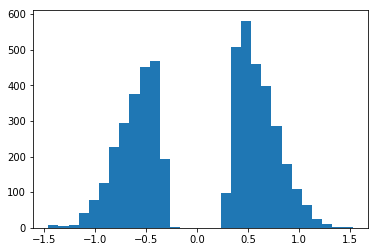

In [12]:
plt.hist((ddm_dat_tmp[0] + optim_results.iloc[0, 1]) * ddm_dat_tmp[1], bins = 30)

In [ ]:
min(ddm_dat_tmp[0])

(array([1.000e+01, 2.500e+01, 4.300e+01, 6.400e+01, 9.900e+01, 1.940e+02,
        3.220e+02, 5.960e+02, 4.200e+02, 7.100e+01, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        7.300e+01, 5.200e+02, 1.076e+03, 6.550e+02, 3.910e+02, 1.680e+02,
        1.300e+02, 8.200e+01, 3.600e+01, 1.700e+01, 5.000e+00, 2.000e+00]),
 array([-1.21      , -1.12466667, -1.03933333, -0.954     , -0.86866667,
        -0.78333333, -0.698     , -0.61266667, -0.52733333, -0.442     ,
        -0.35666667, -0.27133333, -0.186     , -0.10066667, -0.01533333,
         0.07      ,  0.15533333,  0.24066667,  0.326     ,  0.41133333,
         0.49666667,  0.582     ,  0.66733333,  0.75266667,  0.838     ,
         0.92333333,  1.00866667,  1.094     ,  1.17933333,  1.26466667,
         1.35      ]),
 <a list of 30 Patch objects>)

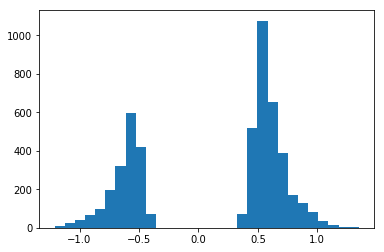

In [9]:
dat_tmp = data.loc[data['file'] == optim_results.iloc[0, 0], ]
plt.hist(dat_tmp['avg_cycles'] * dat_tmp['cnt_err'], bins = 30)

In [ ]:
- (min(dat_tmp['avg_cycles']) - 0.1)

In [ ]:
dat_tmp = data.loc[data['file'] == optim_results.iloc[6, 0], ]

In [ ]:
optim_results = pd.read_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_mle_restricted_range_a_1_2/optim_results.csv')

In [ ]:
optim_results

In [ ]:
plt.scatter(optim_results['v_sim'], optim_results['v_mle'])

In [ ]:
# Regression for v
reg = LinearRegression().fit(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))
reg.score(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))

In [ ]:
plt.scatter(optim_results['a_sim'], optim_results['a_mle'])

In [ ]:
# Regression for a
reg = LinearRegression().fit(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))
reg.score(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))

In [ ]:
plt.scatter(optim_results['w_sim'], optim_results['w_mle'])

In [ ]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))
reg.score(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))

In [ ]:
plt.scatter(optim_results['c1_sim'], optim_results['c1_mle'])

In [ ]:
# Regression for c1
reg = LinearRegression().fit(np.expand_dims(optim_results['c1_mle'], 1), np.expand_dims(optim_results['c1_sim'], 1))
reg.score(np.expand_dims(optim_results['c1_mle'], 1), np.expand_dims(optim_results['c1_sim'], 1))

In [ ]:
plt.scatter(optim_results['c2_sim'], optim_results['c2_mle'])

In [ ]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))
reg.score(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))

In [ ]:
# Code for running other optimization methods... (didn't work though)
#     out = minimize(log_p,
    #                    x0 = np.array([0, 1, 0.5]),
    #                    bounds = [(v_range[0],v_range[1]), 
    #                                            (a_range[0], a_range[1]), 
    #                                            (w_range[0], w_range[1])],
    #                   args = (model, ddm_dat_tmp),
    #                   method = 'Nelder-Mead'
    #                   )
    
    # Print current result